In [1]:
import sys
import scipy.io
import h5py
import numpy as np
import os, sys, time, subprocess, h5py, argparse, logging, pickle
import numpy as np
import pandas as pd
from os.path import join as oj
from copy import deepcopy
from scipy.ndimage import imread
from scipy.misc import imresize
from PIL import Image
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path                   
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from data import Star_dset, Mixed_sam_dset

%matplotlib inline
%load_ext autoreload
%autoreload 2

# star dset

In [45]:
# load dset (takes a few seconds)
dset = Star_dset()
dset.conditions.head()
# dset.conditions

,im_fname,sol_concentration,pressure,time,z_scale,x_y_size,substrate,contact_angle,scan_lines,scan_points_per_line
0,p1_1_5mgml_0002,0.000013,100,0.5,(-5 nm - 15 nm),2.0 μm*2.0 μm,N-(6-aminohexyl)aminopropyltrimethoxysilane(AA...,53,512,1024
1,p1_1_5mgml_0003,0.000013,100,0.5,(-5 nm - 15 nm),2.0 μm*2.0 μm,N-(6-aminohexyl)aminopropyltrimethoxysilane(AA...,53,512,1024
2,p1_1_5mgml_0004,0.000013,100,0.5,(-5 nm - 15 nm),2.0 μm*2.0 μm,N-(6-aminohexyl)aminopropyltrimethoxysilane(AA...,53,512,1024
3,p1_1_5mgml_0005,0.000013,100,0.5,(-5 nm - 15 nm),2.0 μm*2.0 μm,N-(6-aminohexyl)aminopropyltrimethoxysilane(AA...,53,512,1024
4,p1_2_5mgml_0002,0.000013,100,1.5,(-25 nm - 25 nm),3.6 μm*3.6 μm,N-(6-aminohexyl)aminopropyltrimethoxysilane(AA...,53,512,1024


25


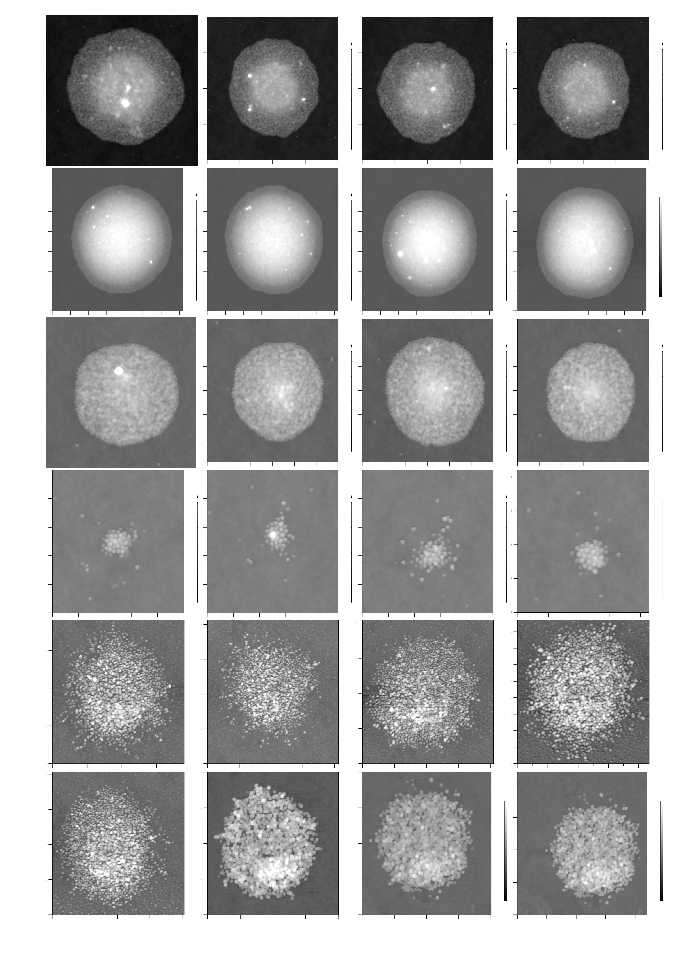

In [23]:
print(len(dset))
# get an example
R, C = 6, 4
plt.figure(figsize=(C*2, R*2), dpi=100)
for i in range(24):
    plt.subplot(R, C, i + 1)
    example = dset[i]
    im = deepcopy(example['im'])
    plt.imshow(im)
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# mixed sam dset

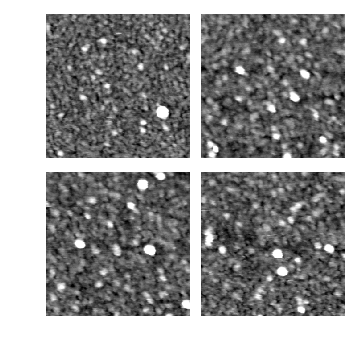

In [10]:
dset_mixed = Mixed_sam_dset()
R, C = 2, 2
plt.figure(figsize=(C*2, R*2), dpi=100)
for i in range(4):
    plt.subplot(R, C, i + 1)
    example = dset_mixed[i]
    im = example['im']
    plt.imshow(im, cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

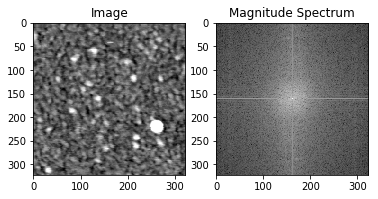

In [11]:
im = deepcopy(dset_mixed[0]['im'])

R, C = 1, 2
plt.subplot(R, C, 1)
plt.imshow(im, cmap='gray')
plt.title('Image')

plt.subplot(R, C, 2)
f = np.fft.fft2(im)
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.log(np.abs(fshift))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')

plt.show()

## try running scat

In [14]:
sys.path.insert(1, oj(sys.path[0], '..', 'visualize/scat_tf'))  # insert parent path                   
from visualize.scat_tf import scattering
import tensorflow as tf
from math import floor

scat = scattering.Scattering(M=32, N=32, J=2, L=8)
# x = torch.randn(1, 3, 32, 32).cuda()
im = deepcopy(dset_mixed[0]['im'])

In [ ]:
J = 2 # spatial scale of filter
L = 8 # number of angular orientations
M, N = 32, 32 # dimensions
scat = scattering.Scattering(M=M, N=N, J=J, L=L) 

# make scat_comp
num_channels = 1 # grayscale or color input
placeholder = tf.placeholder(tf.float32, (1, num_channels, M, N)) # requires NCHW format (cuDNN default - tf is NHWC)
scat_comp = scat(placeholder)
output_middle = floor(scat_comp.shape[-1] / 2)
print("J", J, "L", L, "M", M, "N", N, 'input', placeholder.shape, 'output', scat_comp.shape)
print('expected num filts', int(num_channels * (1 + J* L + J * (J-1) * L * L /2)))

In [ ]:
print('ims.shape before', ims.shape)
ims = np.transpose(ims, (0, 3, 1, 2))  # convert NHWC -> NCHW
print('ims.shape after', ims.shape)
im_shape = ims.shape[1:]
 # can only run on a gpu
# requires NCHW format (cuDNN default - tf is NHWC)
placeholder = tf.placeholder(tf.float32, (None,) + im_shape)
# M, N: input image size
M, N = placeholder.shape.as_list()[-2:]
print("M", M, "N", N)
# J: number of layers
scat = scattering.Scattering(M=M, N=N, J=1)(placeholder)

def extract_features(placeholder, model, ims):
    print('ims.shape', ims.shape)
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    t = time.time()
    output = sess.run(model, feed_dict={placeholder: ims})
    print('features.shape', output.shape)
    return output
 with tf.device("/cpu:0"):
    features = extract_features(placeholder=placeholder, model=scat, ims=im) 